## Assignment: Computer vision course
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of this assignment are:
+ Develop proficiency in using Tensorflow/Keras for training neural nets (NNs).
+ Put in practice Unit 4 knowledge to optimize the parameters and architecture of a feed-forward Neural Net (ffNN), in the context of a computer vision problem.
+ Use NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (cNN).

Follow the link above to download the classification benchmark termed “xview_recognition”: [https://drive.upm.es/s/c4gfDOOwWfPdm0z](https://drive.upm.es/s/c4gfDOOwWfPdm0z")

In [1]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [2]:
categories = {13: 'CARGO_PLANE', 15: 'HELICOPTER', 18: 'SMALL_CAR', 19: 'BUS', 23: 'TRUCK', 41: 'MOTORBOAT', 47: 'FISHING_VESSEL', 60: 'DUMP_TRUCK', 64: 'EXCAVATOR', 73: 'BUILDING', 86: 'STORAGE_TANK', 91: 'SHIPPING_CONTAINER'}

In [3]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories, normalize=False):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    if normalize:
        cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [5]:
import json
# Load database
json_file = '../../xview_recognition/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [6]:
import numpy as np
counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage('../../xview_recognition/' + json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    # Resampling strategy to reduce training time
    if counts[obj.category] >= 5000:
        continue
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'CARGO_PLANE': 628, 'HELICOPTER': 49, 'SMALL_CAR': 5000, 'BUS': 5000, 'TRUCK': 5000, 'MOTORBOAT': 1231, 'FISHING_VESSEL': 736, 'DUMP_TRUCK': 1238, 'EXCAVATOR': 706, 'BUILDING': 5000, 'STORAGE_TANK': 1462, 'SHIPPING_CONTAINER': 1522}


In [7]:
from sklearn.model_selection import train_test_split
anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)

In [8]:
# Load architecture
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
print('Load model')
model = Sequential()
model.add(Flatten(input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(len(categories)))
model.add(Activation('softmax'))
model.summary()

Using TensorFlow backend.


Load model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
activation_1 (Activation)    (None, 150528)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1806348   
_________________________________________________________________
activation_2 (Activation)    (None, 12)                0         
Total params: 1,806,348
Trainable params: 1,806,348
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Learning rate is changed to 0.001
from keras.optimizers import Adam
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.00, amsgrad=True, clipnorm=1.0, clipvalue=0.5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Callbacks
from keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
model_checkpoint = ModelCheckpoint('model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [11]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 16
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [12]:
import math
import numpy as np
print('Training model')
epochs = 20
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit_generator(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model

Epoch 1/20
1551/1551 [==============================] - 88s 57ms/step - loss: 3149.1591 - accuracy: 0.2312 - val_loss: 615.4595 - val_accuracy: 0.3162

Epoch 00001: val_accuracy improved from -inf to 0.31617, saving model to model.hdf5
Epoch 2/20
1551/1551 [==============================] - 84s 54ms/step - loss: 2962.8590 - accuracy: 0.2526 - val_loss: 538.9009 - val_accuracy: 0.2480

Epoch 00002: val_accuracy did not improve from 0.31617
Epoch 3/20
1551/1551 [==============================] - 86s 55ms/step - loss: 3037.7010 - accuracy: 0.2590 - val_loss: 2687.9846 - val_accuracy: 0.2357

Epoch 00003: val_accuracy did not improve from 0.31617
Epoch 4/20
1551/1551 [==============================] - 83s 54ms/step - loss: 2979.5399 - accuracy: 0.2636 - val_loss: 2131.4773 - val_accuracy: 0.2393

Epoch 00004: val_accuracy did not improve from 0.31617
Epoch 5/20
1551/1551 [==============================] - 85s 55ms/step - loss: 2892.0551 - accuracy: 0.2727 - val_loss: 2199.8

#### Testing
Try to improve the results provided in the Moodle competition wiki.

In [13]:
import json
# Load database
json_file = '../../xview_recognition/xview_ann_test.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [14]:
import numpy as np
anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage('../../xview_recognition/' + json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    image.add_object(obj)
    anns.append(image)

In [15]:
import numpy as np
# model.load_weights('model.hdf5', by_name=True)
y_true, y_pred = [], []
for ann in anns:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

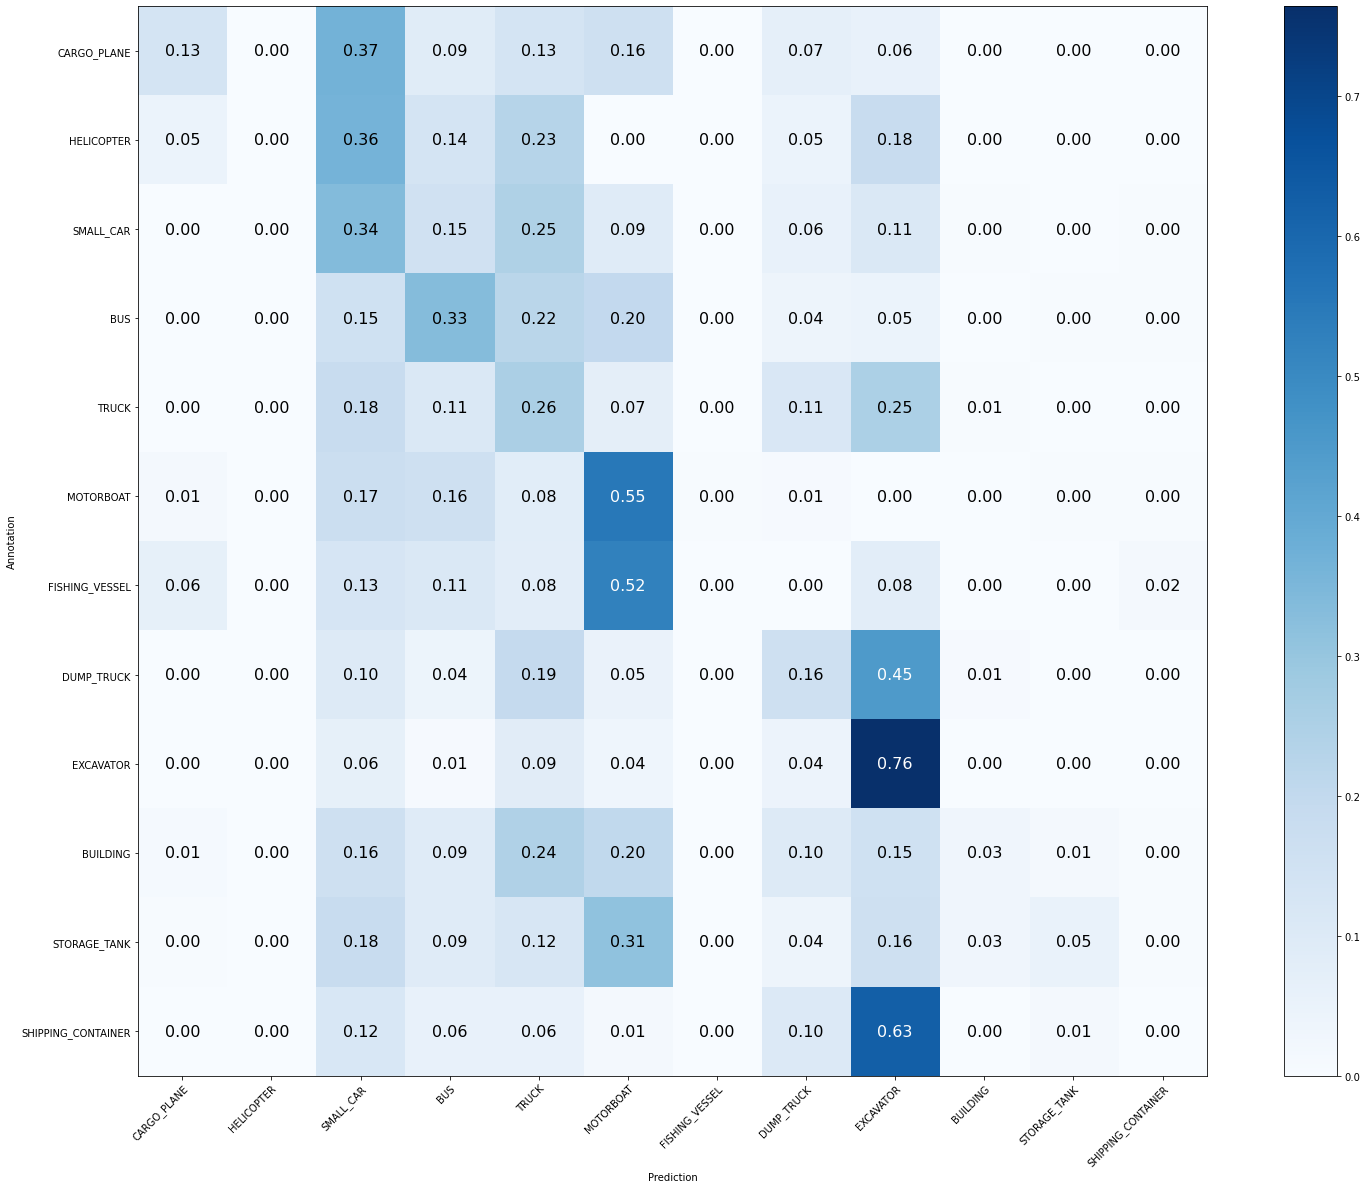

In [16]:
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories, normalize=True)

In [19]:
import numpy as np
# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 13.986%
Mean Recall: 21.780%
Mean Precision: 13.083%
> CARGO_PLANE: Recall: 13.333% Precision: 3.235% Specificity: 99.317% Dice: 5.206%
> HELICOPTER: Recall: 0.000% Precision: 0.000% Specificity: 99.935% Dice: 0.000%
> SMALL_CAR: Recall: 33.509% Precision: 49.407% Specificity: 84.308% Dice: 39.934%
> BUS: Recall: 33.333% Precision: 2.390% Specificity: 88.898% Dice: 4.460%
> TRUCK: Recall: 25.500% Precision: 3.110% Specificity: 75.922% Dice: 5.543%
> MOTORBOAT: Recall: 55.172% Precision: 1.480% Specificity: 83.753% Dice: 2.883%
> FISHING_VESSEL: Recall: 0.000% Precision: 0.000% Specificity: 99.973% Dice: 0.000%
> DUMP_TRUCK: Recall: 15.833% Precision: 0.428% Specificity: 91.590% Dice: 0.834%
> EXCAVATOR: Recall: 76.429% Precision: 1.414% Specificity: 85.800% Dice: 2.777%
> BUILDING: Recall: 3.050% Precision: 92.759% Specificity: 99.595% Dice: 5.906%
> STORAGE_TANK: Recall: 5.200% Precision: 2.772% Specificity: 99.130% Dice: 3.616%
> SHIPPING_CONTAINER: Recall: 0.000% Prec

#### Report
You must prepare a presentation (10 minutes maximum) describing the network architecture, optimization algorithm, regularization (data augmentation, etc…) and performance obtained with your model on the test data set, plots of the evolution of losses and classification performance on the “xview_recognition” task.

Your report should be submitted by Monday, November 14th, 2022, 09:55 (am).